**First Description** 
--
**Task**: Seperating two overlayed  objects in a picture using an *Autoencoder*.\
**Data**: [Columbia Object Image Library (COIL-100) Dataset](https://www.kaggle.com/jessicali9530/coil100)\
The data is mainly pictures of random objects from different angles. We'll create another dataset by overlaying two randomly chosen object pictures from COIL-100.


**Downloading COIL-100 dataset from Kaggle**
---

In [0]:
from google.colab import files
!pip install -q kaggle
files.upload()

In [0]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json  

In [0]:
!kaggle datasets download -d jessicali9530/coil100

 88% 112M/127M [00:01<00:00, 65.5MB/s] 
100% 127M/127M [00:01<00:00, 105MB/s] 


In [0]:
! mkdir coil100 
! unzip coil100.zip -d /content/coil100

**Overlayed Objects Dataset**
---







In [0]:
def remplir(): 
  angles=[]
  for m in range (0,360,5):
      angles.append(m)
  for i in range (0,29,1): 
    k=random.choice(angles)
    angles.append(k)
  return angles

In [0]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from skimage import color
from sklearn.model_selection import train_test_split
import random
from PIL import Image

seperated_images=[]
blended_images= []
for i in range (1,101,1): 
  angles=remplir()
  o=i+1
  for j in range (o,101,1):
    a=random.choice(angles)
    angles.remove(a)
    img1=Image.open("/content/coil100/coil-100/coil-100/obj"+str(i)+"__"+str(a)+".png")
    img2=Image.open("/content/coil100/coil-100/coil-100/obj"+str(j)+"__"+str(355-a)+".png")
    new_img = Image.blend(img1, img2, 0.3)

    img1=image.img_to_array(img1)
    img2=image.img_to_array(img2)
    new_img=image.img_to_array(new_img)
      
    
    img1=img1/255.
    img2=img2/255.
    new_img=new_img/255.


    blended_images.append(new_img)
    seperated_images.append([img1,img2])


X=np.array(blended_images)
Y=np.array(seperated_images)
  

**Examples of Overlayed Images**
---

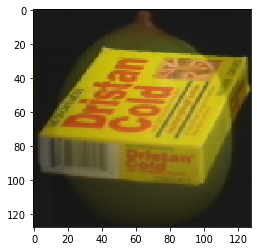

In [0]:
plt.imshow(X[0])


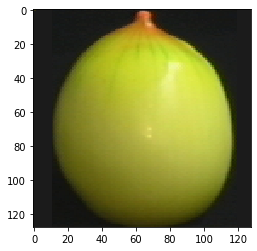

In [0]:
plt.imshow(Y[0][1])

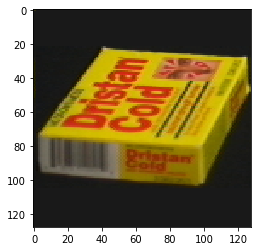

In [0]:
plt.imshow(Y[0][0])

**Train/Test Splitting**
---


In [0]:
Y.shape
Y1=[]
Y2=[]
for i in range (0,4950,1):
  Y1.append(Y[i][0])
  Y2.append(Y[i][1])

In [0]:
split = train_test_split(X, Y1, Y2, test_size=0.2, random_state=13)
(trainX, testX, trainY1,testY1,trainY2, testY2) = split

**Architecture of the Autoencoder**

---


In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D,MaxPooling2D, Conv2DTranspose, Flatten, UpSampling2D

In [0]:
inp = Input(shape=(128,128,3))

#encoder
x=(Conv2D(16,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same', input_shape=(128,128,3)))(inp)
#x=(Dropout(0.25))(x)
x=(Conv2D(32,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)
x=(Conv2D(64,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)

#decoder1
out1=(Conv2DTranspose(64,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)
out1=(Conv2DTranspose(32,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(out1)
#x=(Dropout(0.25))(x)
out1=(Conv2DTranspose(16,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(out1)
#x=(Dropout(0.25))(x)
out1=(Conv2DTranspose(3,kernel_size=(1,1),activation='relu', strides=(1,1), padding='same'))(out1)

#decoder2
out2=(Conv2DTranspose(64,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)
out2=(Conv2DTranspose(32,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(out2)
#x=(Dropout(0.25))(x)
out2=(Conv2DTranspose(16,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(out2)
#x=(Dropout(0.25))(x)
out2=(Conv2DTranspose(3,kernel_size=(1,1),activation='relu', strides=(1,1), padding='same'))(out2)

autoencoder = Model(inp, [out1,out2])

autoencoder.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   12832       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   51264       conv2d_2[0][0]                   
_________________________________________________________________________________________

In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Training**
---

In [0]:
autoencoder.fit(trainX,[trainY1,trainY2],validation_data=(testX,[testY1,testY2]), epochs=40, batch_size=128)

Train on 3960 samples, validate on 990 samples
Epoch 1/40
3960/3960 [==============================] - 141s 36ms/step - loss: 0.9683 - conv2d_transpose_4_loss: 0.4669 - conv2d_transpose_8_loss: 0.5014 - val_loss: 0.9575 - val_conv2d_transpose_4_loss: 0.4605 - val_conv2d_transpose_8_loss: 0.4971
Epoch 2/40
3960/3960 [==============================] - 141s 36ms/step - loss: 0.9546 - conv2d_transpose_4_loss: 0.4591 - conv2d_transpose_8_loss: 0.4955 - val_loss: 0.9540 - val_conv2d_transpose_4_loss: 0.4597 - val_conv2d_transpose_8_loss: 0.4943
Epoch 3/40
3960/3960 [==============================] - 141s 36ms/step - loss: 0.9519 - conv2d_transpose_4_loss: 0.4578 - conv2d_transpose_8_loss: 0.4941 - val_loss: 0.9508 - val_conv2d_transpose_4_loss: 0.4577 - val_conv2d_transpose_8_loss: 0.4931
Epoch 4/40
3960/3960 [==============================] - 141s 36ms/step - loss: 0.9498 - conv2d_transpose_4_loss: 0.4569 - conv2d_transpose_8_loss: 0.4929 - val_loss: 0.9501 - val_conv2d_transpose_4_loss: 0.

**Test and Results**
---

In [0]:
predicted1, predicted2= autoencoder.predict(testX)

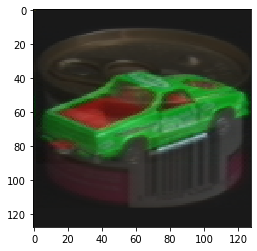

In [0]:
plt.imshow(testX[33])

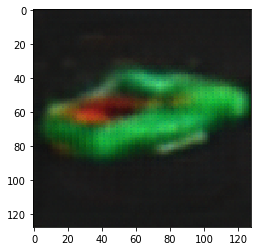

In [0]:
plt.imshow(predicted1[33])

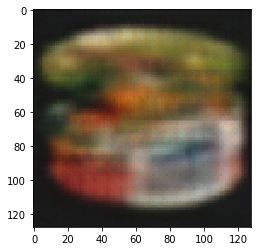

In [0]:
plt.imshow(predicted2[33])